<a href="https://colab.research.google.com/github/lishavin/Amazon/blob/main/GloVe%2BSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Required Packages

- 파일 > Drive에 사본 저장
- 아래 패키지 설치 후 session restart 필요 (런타임 > 세션다시시작)
- drive mount (pretrained weight)

In [1]:
!pip install datasets
!pip install numpy==1.26
!pip install scipy==1.13.1
!pip install gensim
!pip install fsspec==2023.4.0 #"**" 경로 패턴 호환되는 fsspec 옛날버전으로 다운그레이드

!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 561.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 8.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behav

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import nltk #토큰화, 불용어 제거, 표제어 추출 등을 위한 자원 다운로드
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## 1. Load Data

In [3]:
from datasets import load_dataset
df = load_dataset("fancyzhx/amazon_polarity")

# train과 test를 각각 pandas DataFrame으로 변환
train_df = df["train"].select(range(10000)).to_pandas()
test_df = df["test"].select(range(5000)).to_pandas()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [4]:
type(train_df)
type(test_df)

pandas.core.frame.DataFrame

## 2. EDA


- 1 : positive
- 0 : negative

In [5]:
train_df.head()

,label,title,content
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,1,Amazing!,This soundtrack is my favorite music of all ti...
3,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [6]:
#data type 확인
print("Train Dataset DataType")
print(train_df.dtypes)

print("\nTest Dataset DataType")
print(test_df.dtypes)

Train Dataset DataType
label       int64
title      object
content    object
dtype: object

Test Dataset DataType
label       int64
title      object
content    object
dtype: object


In [7]:
train_df.isnull()

,label,title,content
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
9995,False,False,False
9996,False,False,False
9997,False,False,False
9998,False,False,False


In [8]:
#결측치 확인
print("Train Dataset 결측치")
print(train_df.isnull().sum())

print("\nTest Dataset 결측치")
print(test_df.isnull().sum())

Train Dataset 결측치
label      0
title      0
content    0
dtype: int64

Test Dataset 결측치
label      0
title      0
content    0
dtype: int64


label
0    5097
1    4903
Name: count, dtype: int64


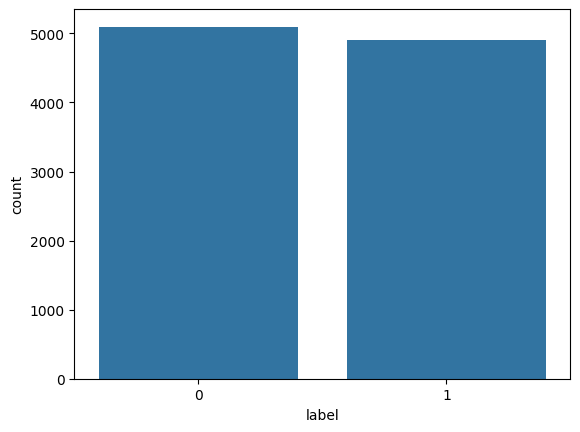

In [9]:
#label 비율 확인
import seaborn as sns
sns.countplot(x='label', data= train_df)
print(train_df.label.value_counts())

label
1    2565
0    2435
Name: count, dtype: int64


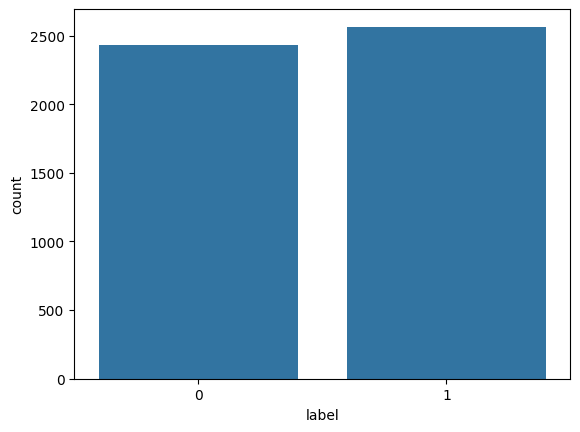

In [10]:
#label 비율 확인
sns.countplot(x='label', data= test_df)
print(test_df.label.value_counts())

In [11]:
train_df

,label,title,content
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,1,Amazing!,This soundtrack is my favorite music of all ti...
3,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
...,...,...,...
9995,1,A revelation of life in small town America in ...,"Though a scholarly biography, the book reveals..."
9996,1,Great biography of a very interesting journalist,"This biography of Arthur Aull, a small-town jo..."
9997,0,Interesting Subject; Poor Presentation,You'd be hard-pressed to tell a boring story a...
9998,0,Don't buy,The box looked used and it is obviously not ne...


## 3. Text Cleaning



>1. 정규표현식
  - HTML 태그 제거
  - 특수문자 제거
2. 소문자 변환
3. Stopwords 제거
4. Stemming (어간 추출) /Lemmatization (표제어 추출)



##### Amazon 데이터에 적용

In [12]:
# title과 content 열 합치기
train_df["review"] = train_df["title"] + " " + train_df["content"]
test_df["review"] = test_df["title"] + " " + test_df["content"]

In [13]:
import re #정규표현식 regular expression: HTML 태그나 특수문자 제거시 사용
import nltk
from nltk.corpus import stopwords #nltk에서 제공하는 불용어(stopwords) 리스트를 불러오기 위한 것
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer #어간 추출, 표제어 추출

# 처음 한 번은 다운로드 필요
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_review(review):
    # HTML 태그 제거
    review = re.sub('<[^>]*>', '', review)
    # 특수 문자 제거 (!는 남기기)
    review = re.sub('[^a-zA-Z0-9 ?]', '', review)
    # 소문자 변환
    review = review.lower()
    # 토큰화
    tokens = word_tokenize(review)
    # 불용어 제거
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # 표제어 추출
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
# 전처리 적용
train_df['processed_review'] = train_df['review'].apply(preprocess_review)
test_df['processed_review'] = test_df['review'].apply(preprocess_review)

In [15]:
train_df.head()

,label,title,content,review,processed_review
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...,Stuning even for the non-gamer This sound trac...,stuning even nongamer sound track beautiful pa...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,The best soundtrack ever to anything. I'm read...,best soundtrack ever anything im reading lot r...
2,1,Amazing!,This soundtrack is my favorite music of all ti...,Amazing! This soundtrack is my favorite music ...,amazing soundtrack favorite music time hand in...
3,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...,Excellent Soundtrack I truly like this soundtr...,excellent soundtrack truly like soundtrack enj...
4,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine...","Remember, Pull Your Jaw Off The Floor After He...",remember pull jaw floor hearing youve played g...


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('title').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('content').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('review').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('processed_review').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['label']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'label'}, axis=1)
              .sort_values('label', ascending=True))
  xs = counted['label']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('label', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('title')):
  _plot_series(series, series_name, i)
  fig.legend(title='title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['label']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'label'}, axis=1)
              .sort_values('label', ascending=True))
  xs = counted['label']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('label', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('content')):
  _plot_series(series, series_name, i)
  fig.legend(title='content', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['label']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'label'}, axis=1)
              .sort_values('label', ascending=True))
  xs = counted['label']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('label', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('review')):
  _plot_series(series, series_name, i)
  fig.legend(title='review', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['label']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'label'}, axis=1)
              .sort_values('label', ascending=True))
  xs = counted['label']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('label', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('processed_review')):
  _plot_series(series, series_name, i)
  fig.legend(title='processed_review', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['content'].value_counts()
    for x_label, grp in _df_8.groupby('title')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('title')
_ = plt.ylabel('content')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['review'].value_counts()
    for x_label, grp in _df_9.groupby('content')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('content')
_ = plt.ylabel('review')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['processed_review'].value_counts()
    for x_label, grp in _df_10.groupby('review')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('review')
_ = plt.ylabel('processed_review')

## 4. Train-Valid Split

In [19]:
from sklearn.model_selection import train_test_split

# 80% train, 20% validation
data_train, data_valid = train_test_split(
    train_df,                  # 원래 train 데이터셋
    test_size=0.2,             # 20%는 validation으로
    stratify=train_df['label'], # label 비율 유지 (긍/부정 균형)
    random_state=42           # 재현성 (같은 split 결과)
)

data_test = test_df           # 테스트는 이미 별도로 있음

In [20]:
len(data_train)

8000

In [21]:
len(data_valid)

2000

## 5. Vectorization + Classifier

##### Glove


In [24]:
# GloVe 벡터 로딩
def load_glove_model(glove_file_path):
    print("Loading GloVe model...")
    glove_model = {}
    with open(glove_file_path, encoding="utf-8") as f:
        for line in tqdm(f):
            parts = line.strip().split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            glove_model[word] = vector
    print(f"{len(glove_model)} words loaded!")
    return glove_model

# 문장 → 평균 벡터 변환
def sentence_to_vector(sentence, glove_model, vector_dim=300):
    tokens = sentence.split()
    vecs = [glove_model[word] for word in tokens if word in glove_model]
    if not vecs:
        return np.zeros(vector_dim)
    return np.mean(vecs, axis=0)

In [25]:
# GloVe 모델 로드 (Stanford에서 사전학습한 모델)
glove_path = "/content/drive/MyDrive/weights/glove.6B.300d.txt"  # 위치 맞게 지정
glove_model = load_glove_model(glove_path)

Loading GloVe model...


400000it [00:39, 10041.54it/s]

400000 words loaded!


In [26]:
glove_model['king']

array([ 0.0033901, -0.34614  ,  0.28144  ,  0.48382  ,  0.59469  ,
        0.012965 ,  0.53982  ,  0.48233  ,  0.21463  , -1.0249   ,
       -0.34788  , -0.79001  , -0.15084  ,  0.61374  ,  0.042811 ,
        0.19323  ,  0.25462  ,  0.32528  ,  0.05698  ,  0.063253 ,
       -0.49439  ,  0.47337  , -0.16761  ,  0.045594 ,  0.30451  ,
       -0.35416  , -0.34583  , -0.20118  ,  0.25511  ,  0.091111 ,
        0.014651 , -0.017541 , -0.23854  ,  0.48215  , -0.9145   ,
       -0.36235  ,  0.34736  ,  0.028639 , -0.027065 , -0.036481 ,
       -0.067391 , -0.23452  , -0.13772  ,  0.33951  ,  0.13415  ,
       -0.1342   ,  0.47856  , -0.1842   ,  0.10705  , -0.45834  ,
       -0.36085  , -0.22595  ,  0.32881  , -0.13643  ,  0.23128  ,
        0.34269  ,  0.42344  ,  0.47057  ,  0.479    ,  0.074639 ,
        0.3344   ,  0.10714  , -0.13289  ,  0.58734  ,  0.38616  ,
       -0.52238  , -0.22028  , -0.072322 ,  0.32269  ,  0.44226  ,
       -0.037382 ,  0.18324  ,  0.058082 ,  0.26938  ,  0.3620

In [28]:
# 각 리뷰를 벡터로 변환
tqdm.pandas()
X_train_vec = data_train['processed_review'].progress_apply(lambda x: sentence_to_vector(x, glove_model, 300))
X_valid_vec = data_valid['processed_review'].progress_apply(lambda x: sentence_to_vector(x, glove_model, 300))
X_test_vec = data_test['processed_review'].progress_apply(lambda x: sentence_to_vector(x, glove_model, 300))

# numpy array로 변환
X_train_vec = np.stack(X_train_vec.values)
X_valid_vec = np.stack(X_valid_vec.values)
X_test_vec = np.stack(X_test_vec.values)

y_train = data_train['label'].values
y_valid = data_valid['label'].values
y_test = data_test['label'].values

100%|██████████| 5000/5000 [00:01<00:00, 3453.87it/s]


In [29]:
print(X_train_vec.shape)
print(X_train_vec[0][:50])

(8000, 300)
[-1.27254754e-01  1.19270004e-01 -1.14059053e-01 -1.27079532e-01
 -3.49795856e-02  5.25418669e-02  1.37897022e-02 -1.64383486e-01
 -5.25028780e-02 -1.16073883e+00  1.07283026e-01  4.44859415e-02
 -1.82927512e-02  2.03364074e-01  1.40852528e-03  1.47705320e-02
 -5.78463562e-02 -1.90051615e-01 -7.02405907e-03 -7.20627084e-02
 -1.19397819e-01  1.51203215e-01 -1.49843276e-01  5.19233681e-02
  1.04579121e-01  2.46765651e-03  1.73340335e-01 -1.61387436e-02
  1.63803533e-01  1.83434095e-02  5.80011196e-02  8.55466798e-02
 -9.93987769e-02 -6.31178118e-05 -8.93291831e-01  1.61556348e-01
 -1.36945531e-01 -6.26666546e-02  1.13561526e-01 -1.22062666e-02
  2.12139949e-01 -1.44219875e-01  3.76897678e-02 -8.12557191e-02
  2.18153987e-02  1.07065894e-01  1.02590285e-01  2.34216750e-01
  2.43194737e-02 -2.34166861e-01]


##### Linear SVM

In [34]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# SVM 모델 정의
svm_clf = SVC(kernel='linear')

# 모델 학습
svm_clf.fit(X_train_vec, y_train)

# 예측
svm_valid_preds = svm_clf.predict(X_valid_vec)
svm_test_preds = svm_clf.predict(X_test_vec)

# 성능 평가
print("Validation Accuracy:", accuracy_score(y_valid, svm_valid_preds))
print("Test Accuracy:", accuracy_score(y_test, svm_test_preds))
print("\n[Classification Report on Test Set]\n", classification_report(y_test, svm_test_preds))

Validation Accuracy: 0.816
Test Accuracy: 0.8042

[Classification Report on Test Set]
               precision    recall  f1-score   support

           0       0.80      0.81      0.80      2435
           1       0.81      0.80      0.81      2565

    accuracy                           0.80      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.80      0.80      0.80      5000



# Cross Validation 1
K-fold 선택: 튜닝 전 baseline 성능을 확인


In [35]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_index, valid_index) in enumerate(kf.split(X_train_vec)):
    X_tr, X_val = X_train_vec[train_index], X_train_vec[valid_index]
    y_tr, y_val = y_train[train_index], y_train[valid_index]

    svm_clf = SVC(kernel='linear')
    svm_clf.fit(X_tr, y_tr)

    val_preds = svm_clf.predict(X_val)
    acc = accuracy_score(y_val, val_preds)
    fold_accuracies.append(acc)

    print(f"[Fold {fold+1}] Validation Accuracy: {acc:.4f}")

print(f"\n📊 Average Validation Accuracy (Baseline - KFold 5): {np.mean(fold_accuracies):.4f}")

[Fold 1] Validation Accuracy: 0.8250
[Fold 2] Validation Accuracy: 0.8269
[Fold 3] Validation Accuracy: 0.8081
[Fold 4] Validation Accuracy: 0.8269
[Fold 5] Validation Accuracy: 0.8087

📊 Average Validation Accuracy (Baseline - KFold 5): 0.8191


# Hyperparameter Tuning

이미 모델 성능이 좋아서 정밀한 전수조사(Grid)보다는 	빠르게 근사 최적값을 찾는 게 더 중요해서 Random Search로 최적 C, penalty 값 찾기


In [36]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# 탐색할 하이퍼파라미터 범위 정의
param_dist = {
    'C': uniform(loc=0.01, scale=10),  # 정규화 파라미터
    'kernel': ['linear'],              # 선형 SVM 고정
}

# RandomizedSearch 정의
random_search = RandomizedSearchCV(
    estimator=SVC(),
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 학습
random_search.fit(X_train_vec, y_train)

# 최적 결과 출력
print("Best Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)

# 최적 모델 추출
best_svm = random_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 0.5908361216819946, 'kernel': 'linear'}
Best CV Accuracy: 0.8206249999999999


# Cross Validation 2
튜닝 후 최종 모델을 재검증: RandomizedSearch 결과가 얼마나 개선됐는지 비교

In [37]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
tuned_fold_accuracies = []

for fold, (train_index, valid_index) in enumerate(kf.split(X_train_vec)):
    X_tr, X_val = X_train_vec[train_index], X_train_vec[valid_index]
    y_tr, y_val = y_train[train_index], y_train[valid_index]

    best_svm.fit(X_tr, y_tr)
    val_preds = best_svm.predict(X_val)
    acc = accuracy_score(y_val, val_preds)
    tuned_fold_accuracies.append(acc)

    print(f"[Fold {fold+1}] Validation Accuracy (Tuned): {acc:.4f}")

print(f"\n✅ Average Validation Accuracy (Tuned - KFold 5): {np.mean(tuned_fold_accuracies):.4f}")

[Fold 1] Validation Accuracy (Tuned): 0.8237
[Fold 2] Validation Accuracy (Tuned): 0.8256
[Fold 3] Validation Accuracy (Tuned): 0.8100
[Fold 4] Validation Accuracy (Tuned): 0.8206
[Fold 5] Validation Accuracy (Tuned): 0.8113

✅ Average Validation Accuracy (Tuned - KFold 5): 0.8183
